In [1]:
import sys
import os
sys.path.append('..')


import torch

from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.ploting import plot_losses, show_images
from comic_ocr.utils.pytorch_model import get_total_parameters_count

# Load/Prepare model

In [2]:
from comic_ocr.models.recognition.crnn.crnn import CRNN

path_output_model = get_path_project_dir('data/output/models/recognition.bin')
print('path_output_model', os.path.abspath(path_output_model))

forcing_new_model = False
if os.path.exists(path_output_model) and not forcing_new_model:
    print('Loading an existing model...')
    model = torch.load(path_output_model)
else:
    print('Creating a new model...')
    model = CRNN.create_small_model()
    
print(model)
print('total_parameters_count', get_total_parameters_count(model))
print('input_height', model.input_height)

path_output_model /Users/wanasit/Workspace/manga-ocr/data/output/models/recognition.bin
Loading an existing model...
CRNN(
  (prediction): Linear(in_features=128, out_features=81, bias=True)
  (transform_image_to_input_tensor): RecognitionInputTransform()
  (feature_extraction_model): Sequential(
    (ConvolutionLayer_0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (ConvolutionLayer_1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [3]:
get_total_parameters_count(model)

482001

## Load/Prepare Dataset

In [4]:
from comic_ocr.models.recognition.recognition_dataset import RecognitionDataset

path_generated_dataset /Users/wanasit/Workspace/manga-ocr/data/output/generate_manga_dataset
generated_dataset 3139


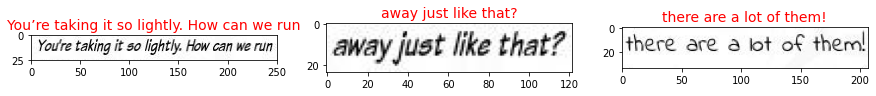

In [5]:
# Load generated dataset
path_generated_dataset = get_path_project_dir('data/output/generate_manga_dataset')
print('path_generated_dataset', os.path.abspath(path_generated_dataset))

generated_dataset = RecognitionDataset.load_generated_dataset(model, path_generated_dataset)
print('generated_dataset', len(generated_dataset))


show_images(
    [generated_dataset.get_line_image(0), generated_dataset.get_line_image(1), generated_dataset.get_line_image(-1)],
    [generated_dataset.get_line_text(0), generated_dataset.get_line_text(1), generated_dataset.get_line_text(-1)],
) 

path_annotated_dataset /Users/wanasit/Workspace/manga-ocr/data/manga_line_annotated
annotated_dataset 1435


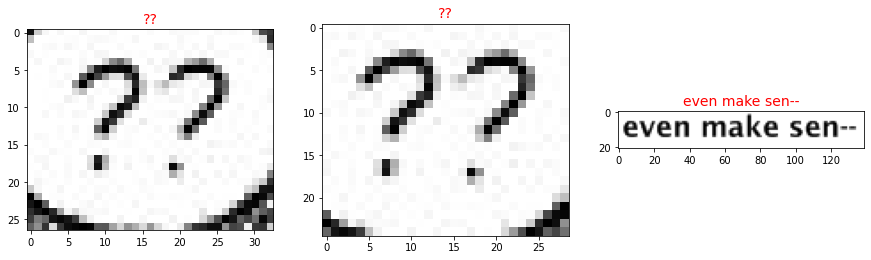

In [6]:
# Load annotated dataset
path_annotated_dataset = get_path_project_dir('data/manga_line_annotated')
print('path_annotated_dataset', os.path.abspath(path_annotated_dataset))


annotated_dataset = RecognitionDataset.load_annotated_dataset(model,
    path_annotated_dataset, random_padding_copy_count=5)
print('annotated_dataset', len(annotated_dataset))

show_images(
    [annotated_dataset.get_line_image(0), annotated_dataset.get_line_image(1), annotated_dataset.get_line_image(-1)],
    [annotated_dataset.get_line_text(0), annotated_dataset.get_line_text(1), annotated_dataset.get_line_text(-1)],
) 

In [7]:
annotated_dataset = annotated_dataset.shuffle('abc')
generated_dataset = generated_dataset.shuffle('abc')

validation_dataset = RecognitionDataset.merge(
    annotated_dataset.subset(to_idx=50), 
    generated_dataset.subset(to_idx=60)
)

training_dataset = RecognitionDataset.merge(
    annotated_dataset.subset(from_idx=50), 
    generated_dataset.subset(from_idx=60, to_idx=2000)
)


print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 110
training_dataset 3325


# Training

In [8]:
from comic_ocr.models.recognition.train import train
from IPython.display import clear_output

def show_example(model, images):
    outputs = [model.recognize(img) for img in images]
    show_images(images, outputs)


def save_and_report(i_epoch, train_losses, val_losses):
    clear_output()
    plot_losses(train_losses, val_losses)
    show_example(model, [
        validation_dataset.get_line_image(0), 
        validation_dataset.get_line_image(1), 
        validation_dataset.get_line_image(2),
        training_dataset.get_line_image(0), 
        training_dataset.get_line_image(1), 
        training_dataset.get_line_image(-1)
    ])
    
    torch.save(model, path_output_model)

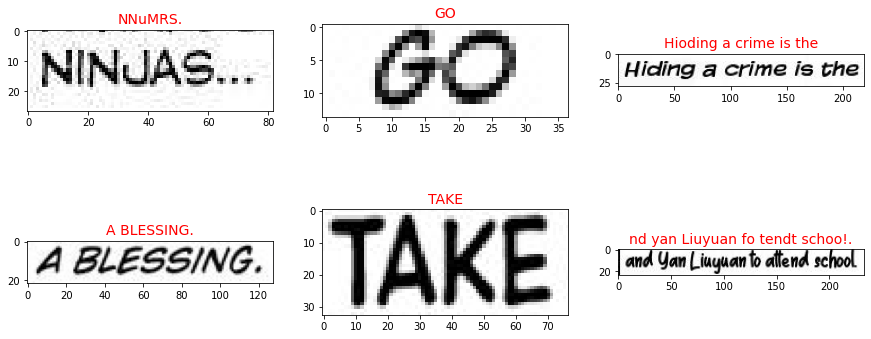

In [9]:
show_example(model, [
    validation_dataset.get_line_image(0), 
    validation_dataset.get_line_image(1), 
    validation_dataset.get_line_image(-1),
    training_dataset.get_line_image(0), 
    training_dataset.get_line_image(1), 
    training_dataset.get_line_image(-1)
])

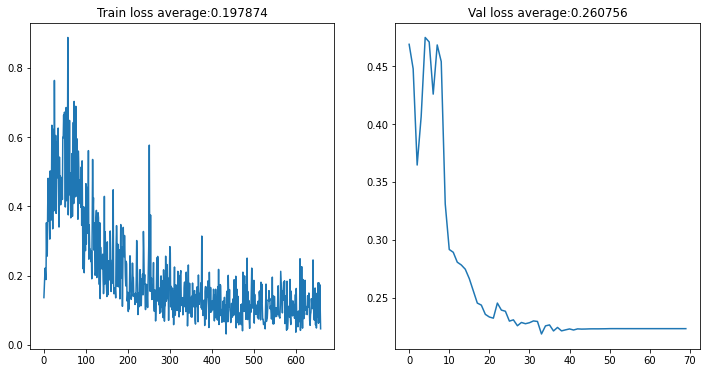

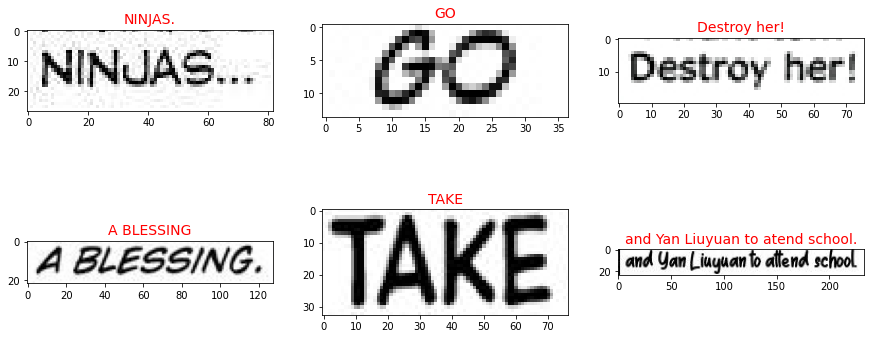

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3325/3325 [01:45<00:00, 31.58it/s, training_batch_loss=0.0463]


In [14]:
#validation_dataset = validation_dataset.subset(to_idx=10)
#training_dataset = training_dataset.subset(to_idx=50)

trains_losses, validation_losses = train(model,
      training_dataset=training_dataset,
      validation_dataset=validation_dataset,
      epoch_count=10,
      batch_size=50,
      epoch_callback=save_and_report,
      update_callback=save_and_report,
      update_every_n=500,
      validation_every_n=500
)

In [16]:
trains_losses[10:]

[0.48073557068128137,
 0.3579202204197645,
 0.4725543266534805,
 0.37230401053093376,
 0.3052412053011358,
 0.5019649408012629,
 0.35997401784174143,
 0.35991345065180214,
 0.44967262582853434,
 0.6338298374088481,
 0.4360915721254423,
 0.334871364440769,
 0.48198904380202295,
 0.6217821165174245,
 0.38686684316024184,
 0.7631815782934427,
 0.5286181901581586,
 0.4456806421838701,
 0.6044235821627081,
 0.3795298367273062,
 0.4950591318361694,
 0.586367136593908,
 0.48228229085740165,
 0.623839659113437,
 0.6254705062974244,
 0.3998942262120545,
 0.34003513635136184,
 0.5418252200260758,
 0.4515323318587616,
 0.48732126426883043,
 0.40422409047372637,
 0.4309697545040399,
 0.4400070057576522,
 0.4836874746531248,
 0.41954045770689846,
 0.5990643849503249,
 0.5976315200701356,
 0.6630394800007343,
 0.598753202855587,
 0.67153085260652,
 0.5586471262201667,
 0.3978312931023538,
 0.5974105860944837,
 0.6850640545785427,
 0.4158719171024859,
 0.49825916569679973,
 0.48960386571474374,
 0.88